# Final Project: Wind Integration in ISO New England
**Eliza Cohn and Julia Simpson**

**EEEL 4220 Fall 2023**

<font color='blue'>**Key information in blue**</font>

# Directions

## Introduction
You take the position of a policy maker to provide policy suggestions to decarbonize ISO New England and are given the attached one-bus system model and. Details about this system model are explained in the attached paper. Note the model in this paper has 8 buses with no transmission limits, so it is equivalent to a single-bus model (ISO New England has minor congestion issues).
ISONE expects to install a total wind generation capacity of 12,000 MW by 2030 and would like to study how to best integrate wind generation. You are provided with one week (168 hours) of data including wind generation capacity factors and demand. The wind generator capacity factor is a normalized value between zero to one representation ratio between the actual wind generation and the installed wind capacity over each hour.

## Project Objective

Please finish a report summarizing how to best integrate **up to 12,000 MW of wind generation** into the system and how the wind generation **would impact the system operating cost**. You should explore three levels of wind capacity:
- Low: 2,000 MW
- Medium: 6,000 MW 
- High: 12,000 MW

You need to implement a unit commitment simulation and explore approaches that could improve the wind integration ratio, these approaches include but are not limited to
- Add carbon tax that increases the cost of traditional generators. You can use the EIA website1 to look up emission factors of different fuel types.
- Add tax incentives for wind integration, in this case, you should add a negative cost of wind generation wt to the objective function.
- Retirement of coal power plants.

At each scenario, use the following indexes to compare the system performance
- The total generation cost.
- The wind curtailment ratio - the ratio between the wind that was not integrated into the system
(Wt − wt) to the total wind capacity available (Wt).
- Profits received by generators.
- The average electricity price.

Finally, your project and report should conclude your recommendation of the best solution that balances electricity cost, system-wide carbon emission, and generator revenue. Note that there will not be a unique solution, and you should use your own judgements about which one you think is the best.

## Directions
1. The major effort in this project is to program a unit commitment model. **Wind generation should be modeled as a zero marginal cost resource (or negative marginal cost if it has tax credits) and can be curtailed**, i.e., wt ≤ WAt, where W are installed wind capacity, At is the time-variant capacity factor given in the data, and wt is the actual wind power integrated into the grid. w should be included in the nodal power balance as a generator. For the rest, please refer to the complete unit commitment formulation in the attachment.
2. You are given a full week’s profile but performing a unit commitment with 168 hours might be overwhelming for your computer. Instead, you should perform sequential daily unit commitments of 24 hours, and pass decision variables as the starting point (in which they become coefficients) for your next unit commitment. These will include $g_{i,t}$ and $u_{i,t}$. You must also update $SU_i$, and $SD_i$ accordingly based on the start-up/down status. For your first operating day, you can assume all generators have been off long enough and set these parameters.
3. The generator cost data includes a quadratic term and a linear term. **You can either use mixed- integer quadratic programming to solve it directly or apply piece-wise linear (five segments per generator max) to the cost curve and convert the problem into MILP.**
4. You can assume all generators are off at the start of each scenario with a zero must-down time, i.e., you can start any generators at the start of the horizon.
5. After implementing a functional unit commitment model, please adjust the installed wind power capacity and other intervention methods, observe the result from each scenario, and summarize the results in your report.

## Wind Tax Incentive

"To receive the full production tax credit amount of 2.6 cents per kilowatt-hour or full investment tax credit of 30%, projects over 1 megawatt must satisfy apprenticeship and prevailing wage requirements. Facilities of under 1 MW are exempt from these requirements. The base credit amount for larger projects that do not meet the wage and apprenticeship requirements is 20% of the full credit amount."

*Source*
- U.S. Department of Energy’s Wind Energy Technologies Office. (n.d.). Production Tax Credit and Investment Tax Credit for Wind Energy. WINDExchange. https://windexchange.energy.gov/projects/tax-credits

**All scenarios (2000MW, 6000 MW, 12000 MW) well over 1MW, so assume projects satisfy apprenticeship and wage requirements such that they're eligible for the full production tax credit of 2.6 cents per kWh – as opposed to taking advantage of the investment tax credit of 30%, since this analysis examines policy impacts on generation costs, not investment costs.**

Objective function in terms of MWh:
$$\frac{2.6 cents}{kWh}\frac{\$}{100 cents}\frac{10^3 kWh}{1MWh} = $26/MWh$$

-<font color='red'>Check: is $w_t$ in MWh or MW? If in MW, need to multiply by the number of hours generating (1 week? or called value?) --> In MW, so need hours. 

Each credit will applied over <font color='red'>1 hr<font color='black'> the relevant wind production, NOT the installed capacity, since it is a production tax credit:
$$\frac{\$26}{MWh}*1 hr = \$26 per MW$$

Since objective function in $\$$:
$$\frac{\$26}{MW} => \$26*w_t[MW]$$

-<font color='red'>Assume hr, since previous approach results in negative operating cost in the millions. Makes sense because objective function summed over all t in hours.

### Objective Function including Wind Tax Incentive

$$ min \sum\limits_{t} \sum\limits_{i} (QC_ig_{i,t}^2 +LC_ig_{i,t} + NLC_iu_{i,t} +SUC_iv_{i,t}) + (9000)s_t - (26)w_t$$

### Constraints

Power balance, the dual variable $\lambda_t$ associated with this constraint is the system price
$$ (1) \sum\limits_{i} g_{i,t} + w_t + s_t = D_t : \lambda_t $$ 

Generation limit constraint $ (i ∈ {1,2,...,I}, t ∈ {1,2,...,T}) $ 
$$ \text{(2)  } Gmin_iu_{i,t} \leq g_{i,t} \leq Gmax_iu_{i,t}$$

Wind generation limit
$$ \text{(3)  } w_t \leq \alpha_tW $$

Generation ramp constraint, the minimum generation limit adds to the ramp-up limit when the generator is turned on or off $(i ∈ {1,2,...,I}, t ∈ {1,2,...,T}) $

$$ \text{(4)  } −Gmin_iz_{i,t} − RR_i ≤ g_{i,t} − g_{i,t−1} ≤ RR_i + Gmin_iv_{i,t} $$

Generator start-up and shut-down logic $(i ∈ {1,2,...,I}, t ∈ {1,2,...,T})$
$$ \text{(5)  } v_{i,t} − z_{i,t} = u_{i,t} − u_{i,t−1} $$
$$ \text{(6)  } v_{i,t} + z_{i,t} ≤ 1 $$

System reserve (3+5 rule: hourly reserve amount must equal to 3% of demand and 5% of integrated wind)
$$ \text{(7)  } \sum\limits_{i} r_{i,t} \geq (3\%) D_t + (5\%)w_t $$
$$ \text{(8)  } r_{i,t} \leq  Gmax_iu_{i,t} − g_{i,t} $$
$$ \text{(9)  } r_{i,t} \leq RR_i $$

#### Min Up/Down Time

Generator minimum up time constraint, note the use of the alternative time index τ , and the constraint only accounts for periods beyond the required must on or off time since the start of the optimization horizon $(i ∈ {1,2,...,I})$
$$ \text{(10)  } \sum\limits_{\tau=max{t−Tup_i+1,1}}^t v_{i,τ} ≤ u_{i,t},t ∈ {SU_i,...,T}$$ 
$$ \text{(11)  } \sum\limits_{\tau=max{t−Tdn_i+1,1}}^t z_{i,τ} ≤ 1-u_{i,t},t ∈ {SD_i,...,T}$$ 


$$ \text{(12)  } \sum\limits_{t=1}^{SU_i} u_{i,t} = SU_i $$
$$ \text{(13)  } \sum\limits_{t=1}^{SD_i} u_{i,t} = 0 $$

#### Calculate SU & SD for Next Day

$$ SU_i = max(Tup_i - \sum_{v_i[\tau] = 1}^t u_{i,t},0)$$
$$\text{Let } v_i[\tau] = 1 \text{ be the time of most recent turn on}$$
$$$$
$$ SD_i = max(Tdn_i - \sum_{z_i[\tau] = 1}^t(1 - u_{i,t}),0) $$
$$\text{Let } z_i[\tau] = 1 \text{ be the time of most recent turn off}$$

In [1]:
def fuel_to_energy(fuel):
    if fuel in ['NUC ',' NUC ']:
        return 'Nuclear' 
    if fuel in [' BIT ', ' SUB ']:
        return 'Coal' 
    if fuel in [' RFO ']:
        return 'Petroleum' 
    if fuel in [' NGLN ', ' NGA4 ', ' NGA1 ', ' NGTN ', ' NGMN ', ' NGIR ', ' NGPN ', ' NGT2 ',' NGT4 ', ' NGT1 ']:
        return 'Natural Gas' 
    return None

In [2]:
def EF(energy):
    if energy in ['Nuclear']:
        return 0
    if energy in ['Coal']:
        return 26.077
    if energy in ['Petroleum']:
        return 26.984
    if energy in ['Natural Gas']:
        return 10.998
    return None

In [3]:
## TOTAL GENERATOR STATUS
def weekly_plot(g, w, s, LOAD, D, T, days, W):
    # Time axis
    x = np.linspace(0, (D+1)*T-1, (D+1)*T) 

    plt.plot(x, g, label = 'Sum of Generator Output')
    plt.plot(x, w, label='Wind Generation', color='g')
    plt.plot(x, s, label='Load Shedding (slack)', color='r')
    plt.plot(x, LOAD, label='Demand', color='b')

    # Adding labels and title
    plt.xlim(0,(D+1)*T-1)
    plt.xticks(np.arange(0, (D+1)*T+1, 12, dtype=int))  # Only integer x ticks
    plt.ylim(0, max(LOAD)+1000)
    plt.xlabel('Time (hours)')
    plt.ylabel('Generation (MW)')
    plt.title(f'Generation, Wind, and Demand for {days} Days')
    # plt.text(0.1, max(LOAD), f'Active Generators: {len(nonzero_gens)}', verticalalignment='center', horizontalalignment='left')

    # Adding a legend
    plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
    
    plt.savefig(f'images/wind-tax-incentive-{W}-integration.png', bbox_inches='tight')

    # Display the plot
    plt.show()

In [4]:
def wind_curtailment_ratio(D, T, W, w):
    Wt = sum(load.WindCF[0:T*(D+1)]*W)
    wt = sum(w)
    return round((Wt-wt)/Wt,2)

## Data Import

In [5]:
import cvxpy as cp
import numpy as np
import gurobipy
import pandas as pd
import matplotlib.pyplot as plt
import time

# Disable SettingWithCopyWarning
pd.set_option('mode.chained_assignment', None)

gen = pd.read_csv('generator_data.csv')
load = pd.read_csv('wind_and_demand.csv')

## Emission Cost
gen['Energy Source'] = gen['Fuel Type']
for index in np.arange(0,len(gen)):
    gen['Energy Source'][index]=fuel_to_energy(gen['Fuel Type'][index])
    
gen['Emission Factor'] = gen['Energy Source']
for index in np.arange(0,len(gen)):
    gen['Emission Factor'][index]=EF(gen['Energy Source'][index])
    
EF = np.array(gen['Emission Factor'].to_list())

## Parameter Load
QC      = gen['Dispatch Cost Quadratic\nCoefficient b \n($/MW^2h)'].ravel() # quadratic gen cost 
LC      = gen['Dispatch Cost Linear\nCoefficient a \n($/MWh)'].ravel()  # marginal generator cost
NLC     = gen['NoLoad\nCost ($)'].ravel()  # no load cost
SUC     = gen['StartUp \nCost ($)'].ravel() # start up cost
GMin    = gen['Minimum generation (MW)'].ravel()  # minium generation
GMax    = gen['Capacity \n(MW)'].ravel()  # maximum generation
RR      = gen['Ramp Rate\n(MW/hr)'].ravel()
Tup     = gen['MinUp\nTime (hr)'].ravel()
Tdn     = gen['MinDown \nTime (hr)'].ravel()

I = gen.shape[0] # number of generators
T = 24; # number of hours

## Variable Definition
g = cp.Variable((I,T), nonneg = True)   # generator dispatch
r = cp.Variable((I,T), nonneg = True)   # hourly reserve generator
w = cp.Variable((T), nonneg = True)   # wind power dispatch
s = cp.Variable((T), nonneg = True)   # slack variable for load shedding

u = cp.Variable((I,T), boolean = True)   # commitment status
v = cp.Variable((I,T), boolean = True)   # start-up status
z = cp.Variable((I,T), boolean = True)   # inverse of start-up status

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Full Week Simulation

Calculating Generation for Day 1!
Generating Constraints...
Solving...
Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-10
Time to solve: 1 minutes
Problem Status: optimal
Total operating cost: 12.06$ Million
Generating Next Day Report...
Day Complete 

Calculating Generation for Day 2!
Generating Constraints...
Solving...
Time to solve: 1 minutes
Problem Status: optimal
Total operating cost: 9.73$ Million
Generating Next Day Report...
Day Complete 

Calculating Generation for Day 3!
Generating Constraints...
Solving...
Time to solve: 5 minutes
Problem Status: optimal
Total operating cost: 8.72$ Million
Generating Next Day Report...
Day Complete 

Calculating Generation for Day 4!
Generating Constraints...
Solving...
Time to solve: 7 minutes
Problem Status: optimal
Total operating cost: 8.39$ Million
Generating Next Day Report...
Day Complete 

Calculating Generation for Day 5!
Generating Constraints...
Solving...
Time to solve: 1 minutes
Problem 

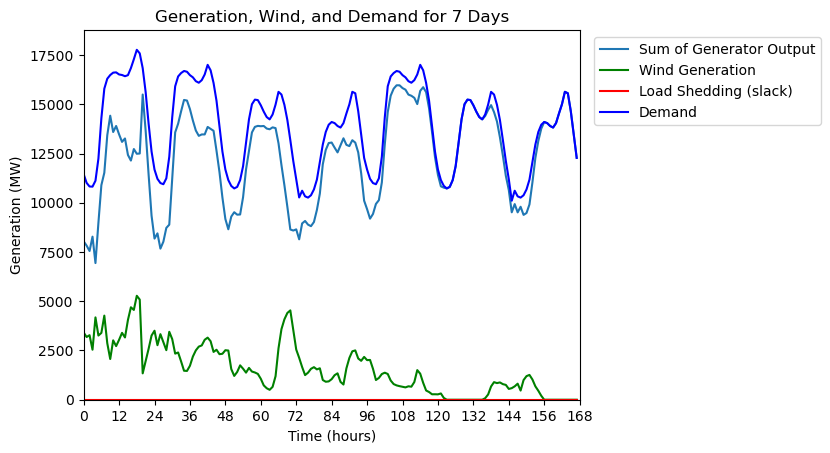

In [6]:
days = 7
total_cost = 0
total_gen = np.array([])
total_wind = np.array([])
total_slack = np.array([])
weekly_u = np.array([])
weekly_v = np.array([])
weekly_z = np.array([])

W = 6000 # Vary Wind Capacty[2000, 6000, 12000]

for D in np.arange(0,days):
    print("Calculating Generation for Day " + str(D+1) + "!")
    
    ## Parameter Definition 
    if D == 0:
        u0      = np.zeros(I)  
        g0      = np.zeros(I)  
        SU0     = np.zeros(I)
        SD0     = np.zeros(I)
    else: 
        report = pd.read_excel(f'report_wind_tax_incentive_{W}.xlsx')
        report = report.drop('Unnamed: 0', axis=1)
        g0      = report['Generator Output EOD ' + str(D-1)]
        u0      = report['Committment Status EOD ' + str(D-1)]
        SU0     = report['SU EOD ' + str(D-1)]
        SD0     = report['SD EOD ' + str(D-1)]

    SU      = np.zeros(I)  # Defined at end of day and saved 
    SD      = np.zeros(I)  # Defined at end of day and saved 
    LOAD    = load.Demand[D*T:T*(D+1)] # Indexing based on run day
    LOAD    = LOAD.reset_index(drop=True)

    alpha = load.WindCF[D*T:T*(D+1)]
    alpha = alpha.reset_index(drop=True)
    
    ## Objective Function
    obj_WIT = cp.Minimize(sum(QC @ g**2 + (LC+EF) @ g + NLC @ u + SUC @ v + 9000*s - 26*w))
    # obj = cp.Minimize(sum(QC @ g**2 + LC @ g + NLC @ u + SUC @ v + 9000*s)) 
    
    ## Constraints
    print("Generating Constraints...")
    con_set = [] 
    for t in range(T): 
        con_set.append(LOAD[t] == sum(g[:, t])+ w[t] + s[t])      # (1) Demand balance constraint 
        con_set.append( w[t] <= alpha[t]*W )                      # (3) Available wind
        con_set.append(sum(r[:,t]) >= 0.03*LOAD[t] + 0.05*w[t])   # (7) Reserve capacity 

        for i in range(I): # go through each generator
            con_set.append(g[i][t] <= GMax[i] * u[i][t])  # (2) Maximum generation limits
            con_set.append(g[i][t] >= GMin[i] * u[i][t])  # (2) Minimum generation limits

            con_set.append(v[i][t] + z[i][t] <= 1)        # (6) Start-up and shut-down logic

            con_set.append(r[i][t] <= GMax[i]*u[i][t] - g[i][t])   # (8) Available reserve 
            con_set.append(r[i][t] <= RR[i])                       # (9) Available reserve ramp rate
            
            if t >= SU0[i]:                               # (10) Min Up Time 
                tau = max(t-Tup[i]+1,1)
                con_set.append(sum(v[i][tau:t]) <= u[i][t])

            if t >= SD0[i]:                               # (11) Min Down Time
                tau = max(t-Tdn[i]+1,1)
                con_set.append(sum(z[i][tau:t]) <= 1 - u[i][t])

            if t==0: 
                con_set.append(v[i][0] - z[i][0] == u[i][0] - u0[i])          # (5) Generator startup-shutdown logic
                con_set.append(g[i][0] - g0[i] <= RR[i] + GMin[i] * v[i][0])  # (4) Assume g0 = g[i][-1] state from previous day 
                con_set.append(g[i][0] - g0[i] >= -GMin[i] * z[i][0] - RR[i]) # (4) Assume g0 = g[i][-1] state from previous day turned on or off
            else:
                con_set.append(v[i][t] - z[i][t] == u[i][t] - u[i][t-1])          # (5) Generator startup-shutdown logic
                con_set.append(g[i][t] - g[i][t-1] <= RR[i] + GMin[i] * v[i][t])  # (4) Max gen limit added to ramp limit when generator turned on or off
                con_set.append(g[i][t] - g[i][t-1] >= -GMin[i] * z[i][t] - RR[i]) # (4) Max gen limit added to ramp limit when generator turned on or off
                
    for i in range(I): 
        if SU0[i]:      # (12) Min Up Time 
            for t in range(int(SU[i])):
                con_set.append(u[i][t] == 1)
        if SD0[i]:      # (13) Min Up Time 
            sd = int(SD[i])
            if sd > T: 
                SD[i] = sd - T 
                sd = T 
            for t in range(sd):
                con_set.append(u[i][t] == 0)
                
    ## Solve and Check Results
    print("Solving...")
    t = time.time()
    prob = cp.Problem(obj_WIT, con_set)
    prob.solve(solver = "GUROBI",MIPGap=0.01)
    prob.solve();
    elapsed = time.time() - t
    print("Time to solve: " + str(round(elapsed/60)) + " minutes")
    print("Problem Status: " + prob.status)
    print("Total operating cost: " + str(round(obj_WIT.value/1e6,2)) + "$ Million")
    
    ## End of Day Accounting
    for i in range(I):
        if np.any(v[i].value): # if it has been turned on 
            turnon_time = np.where(v[i].value)[0][-1] 
            SU[i] = max(Tup[i] - sum(u[i][turnon_time:].value),0) 
        else: 
            SU[i] = 0

        if np.any(z[i].value): # if it has been turned off
            turnoff_time = np.where(z[i].value)[0][-1]
            SD[i] = max(Tdn[i] - sum(1 - u[i][turnoff_time:].value),0)
        else:
            SD[i] = 0
      
    ## Report for Next Day
    print("Generating Next Day Report...")
    report_eod = pd.DataFrame({
    'Generator Output EOD ' + str(D): pd.Series(g.value[:,T-1]), # end of day final values
    'Committment Status EOD ' + str(D): pd.Series(u.value[:,T-1]),
    'SU EOD ' + str(D): pd.Series(SU),
    'SD EOD ' + str(D): pd.Series(SD)
    })
    
    if D == 0: 
        result = report_eod
        weekly_u = u.value
        weekly_v = v.value
        weekly_z = z.value
    else: 
        result = pd.concat([report, report_eod], axis=1) 
        weekly_u = np.concatenate((weekly_u, u.value), axis = 1)
        weekly_v = np.concatenate((weekly_v, v.value), axis = 1)
        weekly_z = np.concatenate((weekly_z, z.value), axis = 1)
        
    result.to_excel(f'report_wind_tax_incentive_{W}.xlsx')
    total_cost += obj_WIT.value
    total_gen = np.concatenate((total_gen, sum(g.value[:])))
    total_wind = np.concatenate((total_wind, w.value))
    total_slack = np.concatenate((total_slack, s.value))
    print("Day Complete \n")
    

print("--WEEKLY REPORT--")
print(f"Installed Wind Capacity: {W}")
print(f"Total Generation Cost: {round(total_cost/1e6,2)} $ Million")
print(f"Wind Curtailment Ratio: {wind_curtailment_ratio(D, T, W, total_wind)}")

## Plots
weekly_plot(total_gen, total_wind, total_slack, load.Demand[:(D+1)*T], D, T, days, W)

## Marginal Price (Fix Binary Indicators)

In [7]:
days = 7
total_cost = []
total_marginalprice = []

total_gen = np.array([])
total_wind = np.array([])
total_slack = np.array([])

for D in np.arange(0,days):
    print("Calculating Generation for Day " + str(D+1) + "!")
    
    u = weekly_u[:,D*T:T*(D+1)]
    v = weekly_v[:,D*T:T*(D+1)]
    z = weekly_z[:,D*T:T*(D+1)]

    ## Parameter Definition 
    if D == 0: 
        g0      = np.zeros(I)  
    else: 
        report = pd.read_excel(f'report_binary_wind_tax_incentive_{W}.xlsx')
        report = report.drop('Unnamed: 0', axis=1)
        g0      = report['Generator Output EOD ' + str(D-1)]

    LOAD    = load.Demand[D*T:T*(D+1)] # Indexing based on run day
    LOAD    = LOAD.reset_index(drop=True)

    alpha = load.WindCF[D*T:T*(D+1)]
    alpha = alpha.reset_index(drop=True)
    
    ## Objective Function
    obj_WIT = cp.Minimize(sum(QC @ g**2 + (LC+EF) @ g + NLC @ u + SUC @ v + 9000*s - 26*w))
    # obj = cp.Minimize(sum(QC @ g**2 + LC @ g + NLC @ u + SUC @ v) + 9000*s) 
    
    ## Constraints
    print("Generating Constraints...")
    con_set = [] 
    
    for t in range(T): 
        con_set.append(LOAD[t] == sum(g[:, t])+ w[t] + s[t])    # (1) Demand balance constraint 
    
    for t in range(T): 
        con_set.append( w[t] <= alpha[t]*W )                    # (3) Available wind
        con_set.append(sum(r[:,t]) >= 0.03*LOAD[t] + 0.05*w[t])   # (7) Reserve capacity 

        for i in range(I): # go through each generator
            con_set.append(g[i][t] <= GMax[i] * u[i][t])  # (2) Maximum generation limits
            con_set.append(g[i][t] >= GMin[i] * u[i][t])  # (2) Minimum generation limits
            con_set.append(r[i][t] <= GMax[i]*u[i][t] - g[i][t])   # (8) Available reserve 
            con_set.append(r[i][t] <= RR[i])                       # (9) Available reserve ramp rate

            if t==0: 
                con_set.append(g[i][0] - g0[i] <= RR[i] + GMin[i] * v[i][0])  # (4) Assume g0 = g[i][-1] state from previous day 
                con_set.append(g[i][0] - g0[i] >= -GMin[i] * z[i][0] - RR[i]) # (4) Assume g0 = g[i][-1] state from previous day turned on or off
            else:
                con_set.append(g[i][t] - g[i][t-1] <= RR[i] + GMin[i] * v[i][t])  # (4) Max gen limit added to ramp limit when generator turned on or off
                con_set.append(g[i][t] - g[i][t-1] >= -GMin[i] * z[i][t] - RR[i]) # (4) Max gen limit added to ramp limit when generator turned on or off
                
    ## Solve and Check Results
    print("Solving...")
    t = time.time()
    prob = cp.Problem(obj_WIT, con_set)
    prob.solve(solver = "GUROBI")
    prob.solve();
    elapsed = time.time() - t
    print("Time to solve: " + str(round(elapsed/60)) + " minutes")
    print("Problem Status: " + prob.status)
    print("Total operating cost: " + str(round(obj_WIT.value/1e6,2)) + "$ Million")
      
    ## Report for Next Day
    print("Generating Next Day Report...")
    report_eod = pd.DataFrame({
    'Generator Output EOD ' + str(D): pd.Series(g.value[:,T-1]), # end of day final values
    })
    
    if D == 0: 
        result = report_eod
    else: 
        result = pd.concat([report, report_eod], axis=1) 
        
    result.to_excel(f'report_binary_wind_tax_incentive_{W}.xlsx')
    
    for i in range(len(con_set)):
        if type(con_set[i]) == cp.constraints.zero.Equality:
            total_marginalprice.append(-con_set[i].dual_value)

    total_cost.append(obj_WIT.value)
    total_gen = np.concatenate((total_gen, sum(g.value[:])))
    total_wind = np.concatenate((total_wind, w.value))
    total_slack = np.concatenate((total_slack, s.value))
    print("Day Complete \n")
    

print("--WEEKLY REPORT--")
print(f"Installed Wind Capacity: {W}")
print(f"Total Generation Cost: {round(sum(total_cost)/1e6,2)} $ Million")
print(f"Wind Curtailment Ratio: {wind_curtailment_ratio(D, T, W, total_wind)}")

Calculating Generation for Day 1!
Generating Constraints...
Solving...
Time to solve: 0 minutes
Problem Status: optimal
Total operating cost: 12.07$ Million
Generating Next Day Report...
Day Complete 

Calculating Generation for Day 2!
Generating Constraints...
Solving...
Time to solve: 0 minutes
Problem Status: optimal
Total operating cost: 9.73$ Million
Generating Next Day Report...
Day Complete 

Calculating Generation for Day 3!
Generating Constraints...
Solving...
Time to solve: 0 minutes
Problem Status: optimal
Total operating cost: 8.72$ Million
Generating Next Day Report...
Day Complete 

Calculating Generation for Day 4!
Generating Constraints...
Solving...
Time to solve: 0 minutes
Problem Status: optimal
Total operating cost: 8.39$ Million
Generating Next Day Report...
Day Complete 

Calculating Generation for Day 5!
Generating Constraints...
Solving...
Time to solve: 0 minutes
Problem Status: optimal
Total operating cost: 13.62$ Million
Generating Next Day Report...
Day Comp

## Cost Analysis

$$ \text{Consumer Cost} = \sum_{t=0}^{T = 168}\lambda_tD_t$$
$$ \lambda_t = \text{Marginal Price at time } t$$

$$ Profit = \sum_{t=0}^{T = 168}\lambda_tD_t - \sum^7_{d=1}Gen. Cost_d $$

In [8]:
avg_price = round(np.average(total_marginalprice[1:]),2) #ignoring the outlier at t = 0
print(f"Average Electricity Price: {avg_price} $/MWh") ## TO DO

consumer_cost = np.dot(total_marginalprice, load.Demand[0:(D+1)*T])
profit = consumer_cost - sum(total_cost)
print(f"Generator Profit: {round(profit/1e6,2)} $M") 

Average Electricity Price: 153.76 $/MWh
Generator Profit: 287.79 $M


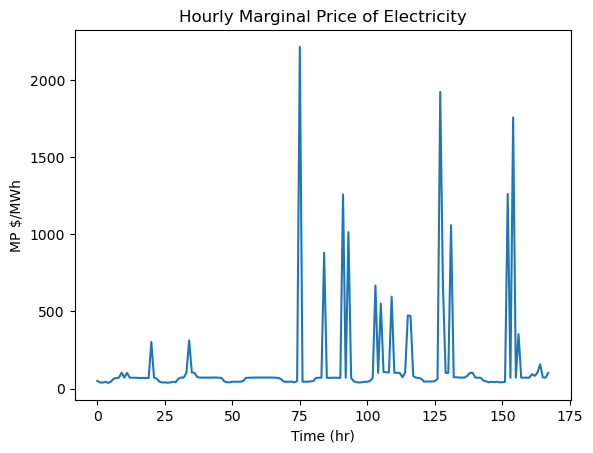

In [9]:
plt.title("Hourly Marginal Price of Electricity")
plt.xlabel('Time (hr)')
plt.ylabel('MP $/MWh')
plt.plot(total_marginalprice)
plt.savefig(f'images/wind-tax-incentive-{W}-integration-marginalprice.png', bbox_inches='tight')
plt.show()

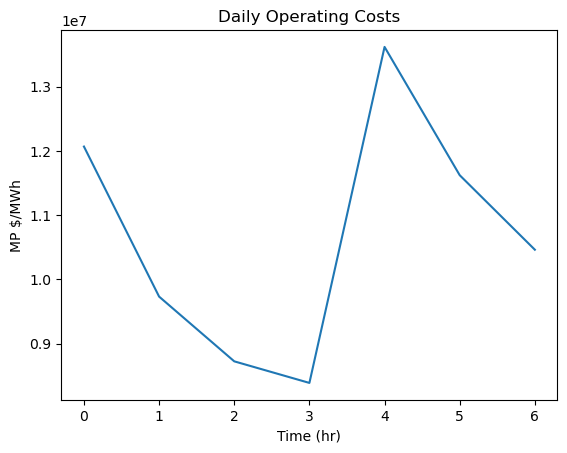

In [10]:
plt.title("Daily Operating Costs")
plt.xlabel('Time (hr)')
plt.ylabel('MP $/MWh')
plt.plot(total_cost)
plt.savefig(f'images/wind-tax-incentive-{W}-integration-opcosts.png', bbox_inches='tight')
plt.show()

In [11]:
total_gen_6000 = total_gen
total_wind_6000 = total_wind
total_slack_6000 = total_slack
marginalprice_6000 = total_marginalprice

In [12]:
simulation = pd.DataFrame({
    'Generator Output': total_gen_6000, 
    'Wind Output': total_wind_6000,
    'Slack Output': total_slack_6000,
    'Marginal Price': marginalprice_6000
    })
simulation.to_excel(f'wind-tax-incentive-{W}-simulation.xlsx')

In [13]:
total_gen_2000 = total_gen
total_wind_2000 = total_wind
total_slack_2000 = total_slack
marginalprice_2000 = total_marginalprice

In [ ]:
# Save sim data

## APPENDIX

In [ ]:
## INDIVIDUAL GENERATOR STATUS
# Return generators that turned on at any time t and their original index
nonzero_gens = [(i, row) for i, row in enumerate(g.value) if np.any(row != 0)]

# Time axis
x = np.linspace(0, T-1, T) 

# Plotting the active generators
I_no0 = len(nonzero_gens)
for i in range(I_no0):
    plt.plot(x, nonzero_gens[i][1],label=f'Generator {nonzero_gens[i][0]}')
    
plt.plot(x, w.value, label='Wind Generation', color='g')
plt.plot(x, s.value, label='Load Shedding (slack)', color='r')
# plt.plot(x, LOAD, label='Demand', color='b')

# Adding labels and title
plt.xlim(0,T-1)
plt.xticks(x)  # Only integer x ticks
#plt.ylim(0, max(LOAD)+1000)
plt.xlabel('Time (hours)')
plt.ylabel('Generation (MW)')
plt.title(f'Active Generators, Wind, and Demand for Day {D+1}')
plt.text(0.1, 1300, f'Active Generators: {len(nonzero_gens)}', verticalalignment='center', horizontalalignment='left')

# Adding a legend
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))

# Display the plot
plt.show()

In [ ]:
# Plot Wind Capacity
plt.plot(load.WindCF*W)
plt.title('Available Wind Capacity')
plt.xlabel('Hours')
plt.ylabel('MW')
plt.show()